# Transition Tuples for Covid + Patients

* What are the units for o2 saturation?
* Can we have more finegrained actions? 

In [8]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pth = "/tigress/BEE/penn-covidsub/wip-state_rep_all_feat_24H.csv"
#pth = '/tigress/BEE/penn-covidsub/COVID - boosting_24H.csv'

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='O2 SAT MEASURED', ylabel='Density'>

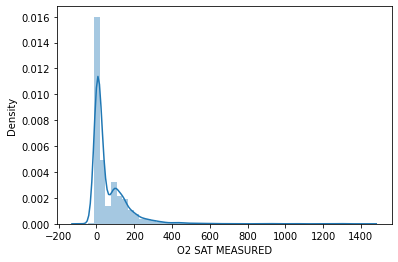

In [9]:
respiratory_rate_cols = ['MEASURED O2 SAT VEN', 'MEASURED O2 SAT ART', 'C O2 SAT MEASURED', 'C O2 SAT',
                        'O2 SAT MEASURED']
data = pd.read_csv(pth)
o2 = data[respiratory_rate_cols]
sns.distplot(o2['O2 SAT MEASURED'])

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

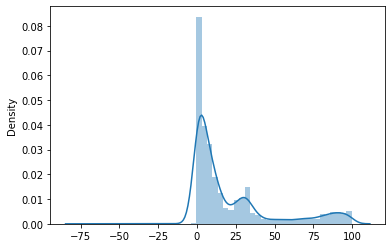

In [10]:
sns.distplot(o2[o2['O2 SAT MEASURED'] < 100])

In [ ]:
allFrames = pd.read_csv(pth)
state_feats = ['ALBUMIN', 'ANION GAP',
       'BASE EXCESS', 'BICARBONATE', 'BILIRUBIN', 'CALCIUM',
       'CARBOXYHEMOGLOBIN', 'CHLORIDE', 'CREATININE', 'HEMATOCRIT',
       'HEMOGLOBIN', 'INSPIRED OXYGEN', 'INTERNATIONAL NORMALIZED RATIO',
       'LACTATE', 'METHEMOGLOBIN', 'PARTIAL THROMBOPLASTIN TIME', 'PCO2', 'PH',
       'PLATELETS', 'PO2', 'POTASSIUM', 'SODIUM', 'UREA NITROGEN',
       'URINE OUTPUT', 'WHITE BLOOD CELLS', 'FIO2', 'PEEP', 'OXYGEN (L)',
       'Respiratory Aids', 'Nonsteroidal Anti-inflammatory Agents (NSAIDs)',
       'Corticosteroids - Topical', 'Mineralocorticoids',
       'Glucocorticosteroids', 'Influenza Agents', 'Antiretrovirals',
       'is_deceased_next_t']

In [ ]:
allFrames

In [ ]:
def state_transformer(frames, states=None, feats=state_feats, transformer='tuples/transformer.pkl'):
   
    print('#:', len(feats))
    if states is None:
        states = np.vstack([np.array(frames.loc[i, feats]).astype(float) for i in range(len(frames))])
    if False: #os.path.isfile(transformer):
        scaler = pickle.load(open(transformer, 'rb'))
    else:
        scaler = preprocessing.StandardScaler().fit(states)
        pickle.dump(scaler, open('tuples/transformer.pkl', 'wb'))
    transformed_states = scaler.transform(states)
    return transformed_states

def state_invtransformer(tstates, transformer='tuples/transformer.pkl'):
    
    scaler = pickle.load(open(transformer, 'rb'))
    states = scaler.inverse_transform(tstates)
    
    return states

def transform(state, transformer='tuples/transformer.pkl'):
    if os.path.isfile(transformer):
        scaler = pickle.load(open(transformer, 'rb'))
        return scaler.transform([state])[0]
    else:
        return state
    return 

def discretize(a, el='Respiratory Aids'):
    
    print("A ", a )
    if el=='Respiratory Aids':
        adict = {'none': 0, 'vent': 0}
        
        # What is ivd, ivh?
        aid = a[0]
        
        if aid:
            adict['vent'] = 1        
        
    da = list(adict.values())
    if sum(da) == 0: da[0] = 1

    return da

def reward(s, a, ns, w=np.array([1, 1])/5., el='Respiratory Aid'):
    
    rdict = {'cost-vent': 0, 'low-o2sat': 0}
    
    if a[0] > 0 : rdict['cost-iv'] -= 1 
    if a[1] > 0 : rdict['cost-po'] -= 1
    
    if el=='Respiratory Aid': rdict['cost-vent'], rdict['low-02sat'] = sigmoid(ns[0], el=el)
    if el=='Mg': rdict['high'], rdict['low'] = sigmoid(ns[1], el=el)
    if el=='P': rdict['high'], rdict['low'] = sigmoid(ns[2], el=el)
    
    phi = np.array(list(rdict.values()))
    r = np.dot(phi, w)
    
    return phi, r

def sigmoid(x, el='K'):
    
    minmax = {'K': [3.5, 4.5], 'Mg': [1.5, 2.5], 'P': [2.5, 4.5]}
    lmin, lmax = minmax[el]
    
    if x < lmin:
        z = 1/(1 + np.exp(-3.5*(x-(lmin-1)))) - 1
        return (0, z)
    elif x > lmax: 
        z = - 1/(1 + np.exp(-3.5*(x-(lmax+1))))
        return (z, 0)
    else:
        z = 0
        return (z, z)
    
def generate_samples(vnum, trainFrames, el='Respiratory Aids'):

    frame = trainFrames[trainFrames.pat_id==vnum]
    all_st = []
    all_nst = []
    all_a = []
    all_phi = []
    all_r = []

    for i in frame.index[:-1]:
        
        s = list(frame.loc[i, state_feats])
        st = transform(s)
        all_st.append(st)
        if el=='Respiratory Aids':
            a = list(frame.loc[i+1, ['Respiratory Aids']])
        da = discretize(a, el=el)
        all_a.append(da)
        ns = list(frame.loc[i+1, state_feats])
        nst = transform(ns)
        all_nst.append(nst)
        phi, r = reward(s, a, ns, el=el) 
        all_phi.append(phi)
        all_r.append(r)
        #print('s:', s, '\n\na:', a, '\n\nns', ns, '\n\nr', phi, r)
        
    return (all_st, all_a, all_nst, all_phi, all_r)

def combine(ent):
    return np.concatenate(np.array(ent))

def get_tuples(frames, filename='tuples.pkl', el='Respiratory Aids'):
    
    transition_tuples = {'s': [], 'a': [], 'ns': [], 'phi': [], 'r': [], 'vnum': []}
    
    if el=='Respiratory Aids':
        visits = frames[(frames['Respiratory Aids']!=0)].pat_id.unique()
        
    for vnum in visits:
        if len(frames[frames.pat_id==vnum]) > 1:
            s, a, ns, phi, r = generate_samples(vnum, frames, el)
            transition_tuples['s'].append(np.array(s))
            transition_tuples['a'].append(np.array(a))
            transition_tuples['ns'].append(ns)
            transition_tuples['phi'].append(phi)
            transition_tuples['r'].append(r)
            transition_tuples['vnum'].append(np.repeat(vnum, len(r)))

    for k in transition_tuples.keys():
        transition_tuples[k] = combine(transition_tuples[k])
    
    print(str(transition_tuples))
    pickle.dump(transition_tuples, open(cf.outputdir + filename, 'wb'))
    
    return transition_tuples

In [ ]:
print('Total number of processed adms =', len(allFrames.pat_id.unique()),'; number of transitions =', len(allFrames))    
allFrames = allFrames.sort_values(by=['pat_id', 'order_time'])
bp = np.sort(allFrames.pat_id.unique())[75]
trainFrames = allFrames[allFrames['pat_id'] < bp].reset_index()
testFrames = allFrames[allFrames['pat_id'] >= bp].reset_index()
trainFrames.to_csv('tuples/trainFrames.csv', index=False)
testFrames.to_csv('tuples/testFrames.csv', index=False)
print('Transformer')
ts = state_transformer(trainFrames)
visits = allFrames.pat_id.unique()

In [ ]:
print('Training set:')
print('Total number of processed adms =',len(trainFrames.pat_id.unique()),'; number of transitions =',len(trainFrames))
print ('Respiratory Aids Cohort')
print('Number given respiratory aids =', len(allFrames[allFrames["Respiratory Aids"] != 0].pat_id.unique()))
print('Get tuples')
get_tuples(trainFrames, filename='train_resp_tuples.pkl', el='Respiratory Aids')